# **Step 1: Libraries and Data Downloading**

In [ ]:
!pip install shap
# Install compatible versions of torch and torchtext
!pip install torch==2.0.1
!pip install torchtext==0.15.2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from wordcloud import WordCloud
import spacy
import re
import shap

## **Download Data**

In [3]:
!gdown --id 1zcDOotHJ3tvYE67ecR8fJrM1sXv-elLH

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zcDOotHJ3tvYE67ecR8fJrM1sXv-elLH
To: /content/amazon.csv
100% 3.61M/3.61M [00:00<00:00, 22.3MB/s]


# **Step 2: Data Loading and Initial Processing and Visualization**

In [4]:
data = pd.read_csv('amazon.csv')


In [5]:
import spacy
nlp = spacy.load("en_core_web_sm")

## **Exploratory Data Analysis (EDA) for Data Before Cleaning**

In [6]:
print("\nBasic Data:")
data.head()


Basic Data:


,reviewText,Positive
0,This is a one of the best apps acording to a b...,1
1,This is a pretty good version of the game for ...,1
2,this is a really cool game. there are a bunch ...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


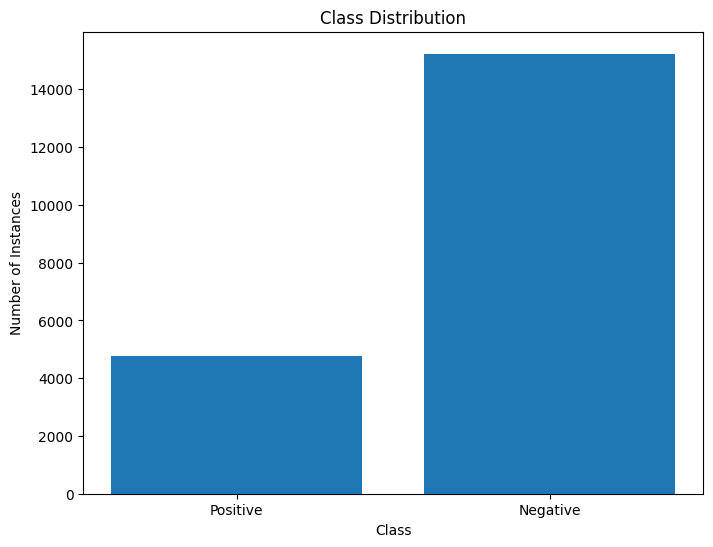

In [7]:
import matplotlib.pyplot as plt

# Count the number of instances for each class
class_counts = data['Positive'].value_counts()

# Create a bar plot of the class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution')
plt.xticks(class_counts.index, ['Negative', 'Positive'])
plt.show()

([<matplotlib.patches.Wedge at 0x7b7bfcce73a0>,
 [Text(-0.8057580416543408, 0.748835080848488, 'Positive'),
  Text(0.8057581117653374, -0.7488350054079725, 'Negative')])

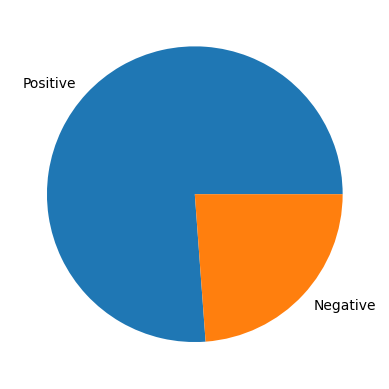

In [8]:
label = ["Positive","Negative"]
values = data['Positive'].value_counts()
plt.pie(labels = label, x = values)

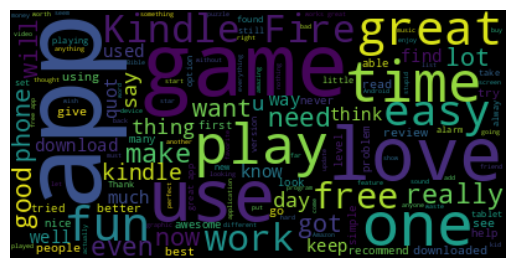

In [9]:
# Assuming 'data' contains a column named 'reviewText' with text reviews.
text = " ".join(review for review in data.reviewText) # Changed 'data.Review' to 'data.reviewText'

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Convert to lowercase and remove HTML tags and punctuations**

In [10]:
nlp = spacy.load("en_core_web_sm")
data['clean_review'] = data['reviewText'].str.lower()
data['clean_review'] = data['clean_review'].str.replace(r'<[^<>]*>', '', regex=True)
data['clean_review'] = data['clean_review'].str.replace('[^\w\s]', '', regex=True)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [11]:
data.head()

,reviewText,Positive,clean_review
0,This is a one of the best apps acording to a b...,1,this is a one of the best apps acording to a b...
1,This is a pretty good version of the game for ...,1,this is a pretty good version of the game for ...
2,this is a really cool game. there are a bunch ...,1,this is a really cool game there are a bunch o...
3,"This is a silly game and can be frustrating, b...",1,this is a silly game and can be frustrating bu...
4,This is a terrific game on any pad. Hrs of fun...,1,this is a terrific game on any pad hrs of fun ...


## **Tokenization and Lemmatization**


In [12]:
data['clean_review'] = data['clean_review'].apply(lambda row: [token.lemma_ for token in nlp(row)])

In [13]:
data.head()

,reviewText,Positive,clean_review
0,This is a one of the best apps acording to a b...,1,"[this, be, a, one, of, the, good, app, acorde,..."
1,This is a pretty good version of the game for ...,1,"[this, be, a, pretty, good, version, of, the, ..."
2,this is a really cool game. there are a bunch ...,1,"[this, be, a, really, cool, game, there, be, a..."
3,"This is a silly game and can be frustrating, b...",1,"[this, be, a, silly, game, and, can, be, frust..."
4,This is a terrific game on any pad. Hrs of fun...,1,"[this, be, a, terrific, game, on, any, pad, hr..."


# **Step 3: Stopwords Removal**

In [14]:
doc = nlp.Defaults.stop_words
doc.add("")
doc.add(" ")

def remove_stopwords(tokens):
    return [word for word in tokens if word not in doc]

data['clean_review'] = data['clean_review'].apply(remove_stopwords)

## **Combine tokens back into a single string**

In [15]:
data['clean_review'] = data['clean_review'].apply(lambda row: ' '.join(row))


In [16]:
data.head()

,reviewText,Positive,clean_review
0,This is a one of the best apps acording to a b...,1,good app acorde bunch people I agree bomb egg ...
1,This is a pretty good version of the game for ...,1,pretty good version game free lot different le...
2,this is a really cool game. there are a bunch ...,1,cool game bunch level find golden egg super fun
3,"This is a silly game and can be frustrating, b...",1,silly game frustrating lot fun definitely reco...
4,This is a terrific game on any pad. Hrs of fun...,1,terrific game pad hrs fun grandkid love great ...


# **Step 4: Balancing Data (Resampling)**


In [17]:
minority_class = data[data['Positive'] == 0]
majority_class = data[data['Positive'] == 1]
minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
balanced_data = pd.concat([majority_class, minority_upsampled])

In [18]:
print("Class Distribution After Balancing:")
print(balanced_data['Positive'].value_counts())

Class Distribution After Balancing:
Positive
1    15233
0    15233
Name: count, dtype: int64


## **Save cleaned data**

In [19]:
balanced_data.to_csv('cleaned_data.csv', index=False)


# **Step 5: Predict the Sentiment Using Traditional ML models**

### **Feature Extraction using TF-IDF**

In [20]:
X = balanced_data['clean_review']
y = balanced_data['Positive']

In [21]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

print("TF-IDF Feature Shapes:")
print("Train:", X_train_features.shape)
print("Test:", X_test_features.shape)s

TF-IDF Feature Shapes:
Train: (24372, 17977)
Test: (6094, 17977)


## **Model Training and Evaluation**

In [22]:
# Function to Evaluate Models
def evaluate_model(model, X_test, y_test):
    y_predict = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)

    return accuracy, precision, recall, f1

## **5.1: Naive Bayes Classifier**

In [23]:
nb_model = MultinomialNB()
nb_model.fit(X_train_features, y_train)

nb_accuracy, nb_precision, nb_recall, nb_f1 = evaluate_model(nb_model, X_test_features, y_test)
print("Naive Bayes Evaluation:")
print(f"Accuracy: {nb_accuracy:.4f}, Precision: {nb_precision:.4f}, Recall: {nb_recall:.4f}, F1 Score: {nb_f1:.4f}")

Naive Bayes Evaluation:
Accuracy: 0.8910, Precision: 0.9032, Recall: 0.8792, F1 Score: 0.8910


In [24]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
berNB =  BernoulliNB()
berNB.fit(X_train_features, y_train)

berNB_accuracy, berNB_precision, berNB_recall, berNB_f1 = evaluate_model(berNB, X_test_features, y_test)
print("Naive Bayes Evaluation BernoulliNB:")
print(f"Accuracy: {berNB_accuracy:.4f}, Precision: {berNB_precision:.4f}, Recall: {berNB_recall:.4f}, F1 Score: {berNB_f1:.4f}")

Naive Bayes Evaluation BernoulliNB:
Accuracy: 0.8958, Precision: 0.9184, Recall: 0.8717, F1 Score: 0.8945


## **5.2 Logistic Regression Classifier**

In [25]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_features, y_train)

lr_accuracy, lr_precision, lr_recall, lr_f1 = evaluate_model(lr_model, X_test_features, y_test)
print("\nLogistic Regression Evaluation:")
print(f"Accuracy: {lr_accuracy:.4f}, Precision: {lr_precision:.4f}, Recall: {lr_recall:.4f}, F1 Score: {lr_f1:.4f}")



Logistic Regression Evaluation:
Accuracy: 0.8953, Precision: 0.9099, Recall: 0.8805, F1 Score: 0.8950


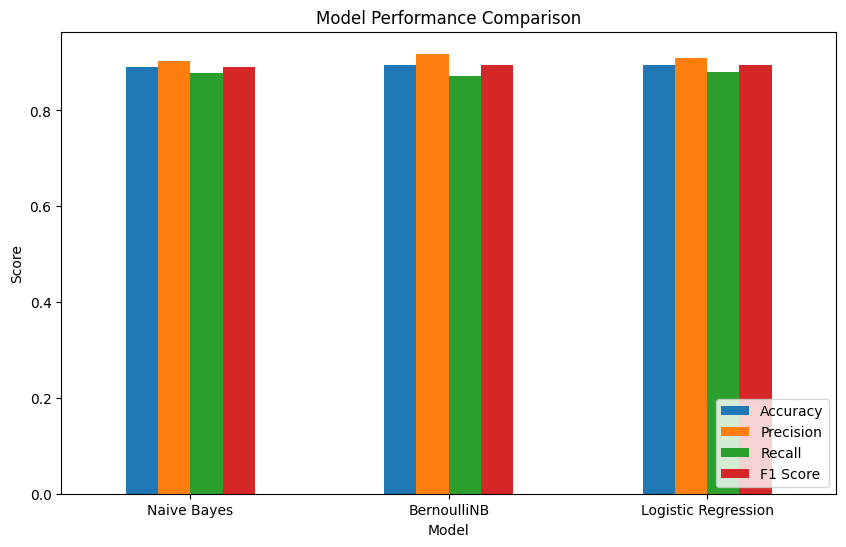

In [26]:
metrics = {
    'Naive Bayes': [nb_accuracy, nb_precision, nb_recall, nb_f1],
    'BernoulliNB': [berNB_accuracy, berNB_precision, berNB_recall, berNB_f1],
    'Logistic Regression': [lr_accuracy, lr_precision, lr_recall, lr_f1]
}

metrics_df = pd.DataFrame(metrics, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Transpose the DataFrame for better visualization
metrics_df = metrics_df.T

# Plotting the metrics
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

# **Step 6: Feature Importance (Logistic Regression)**

In [27]:
feature_names = vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# Top 10 Positive Features
top_positive_features = feature_importance_df.sort_values(by="Coefficient", ascending=False).head(10)
print("\nTop 10 Positive Features:")
print(top_positive_features)

# Top 10 Negative Features
top_negative_features = feature_importance_df.sort_values(by="Coefficient").head(10)
print("\nTop 10 Negative Features:")
print(top_negative_features)


Top 10 Positive Features:
         Feature  Coefficient
7213       great     9.370615
9625        love     9.102728
5177        easy     6.691709
1910     awesome     6.323033
11629    perfect     4.947227
6615         fun     4.602167
5657   excellent     4.007018
10677       nice     3.806457
860    addictive     3.709194
1218     amazing     3.667585

Top 10 Negative Features:
          Feature  Coefficient
17237       waste    -7.216058
4366       delete    -6.611298
16620  uninstalle    -5.638921
2507       boring    -5.390045
15151        suck    -5.273502
15079      stupid    -5.027316
16837     useless    -4.785328
6198          fix    -4.492366
2501         bore    -4.478986
2005          bad    -4.368870


# **Step 7: Applying different Tokenization/Vectorization techniques**

In [ ]:
!gdown 17GZKyRcV70JsLt8xQqFY_vV1IYUmZcau

In [85]:
import pandas as pd

# Load dataset
balanced_data = pd.read_csv('cleaned_data.csv')
balanced_data = balanced_data.dropna()
balanced_data = balanced_data[["clean_review", "label"]]

In [86]:
balanced_data.head()

,clean_review,label
0,good app acorde bunch people agree bomb egg pi...,1
1,pretty good version game free lot different le...,1
2,bunch level find golden egg super fun,1
3,silly game frustrating lot fun definitely reco...,1
4,terrific game pad hrs fun grandkid love great ...,1


 ## **Install Necessary Libraries**

In [ ]:
!pip install transformers datasets torchtext gensim

## **Train-Test Split**

In [88]:
from datasets import Dataset

# Convert pandas DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(balanced_data)
train_test_split = dataset.train_test_split(test_size=0.2)
train_df = train_test_split['train']
test_df = train_test_split['test']

## **Vectorization Techniques**

we will Implement different vectorization/tokenization techniques: **BERT**, **GloVe**, **Word2Vec**, and **Doc2Vec**.

## **7.1 BERT Tokenization**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load BERT tokenizer and model
model_name = "distilbert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)



In [89]:
# Tokenize dataset for BERT
def bert_preprocess_function(examples):
    return bert_tokenizer(examples['clean_review'], padding="max_length", truncation=True)


In [ ]:
# Apply BERT Tokenization
bert_train = train_df.map(bert_preprocess_function, batched=False)
bert_test = test_df.map(bert_preprocess_function, batched=False)


In [92]:
# Format for PyTorch
bert_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
bert_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

## **7.2 GloVe Embedding Vectorization**

In [ ]:
#!pip uninstall torchtext torch
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
#!pip install torchtext

In [ ]:
from torchtext.vocab import GloVe
import numpy as np
# Use GloVe embeddings
def glove_vectorization(df, embedding_dim=100):
    glove = GloVe(name='6B', dim=embedding_dim)
    vectors = []

    for sentence in df['clean_review']:
        tokens = sentence.split()  # Simple tokenization by splitting
        vector = np.mean([glove[token].numpy() for token in tokens if token in glove.stoi], axis=0)
        vectors.append(vector)

    # Convert the Dataset object to a pandas DataFrame for modification
    df = df.to_pandas()
    df['vector'] = vectors
    return df
# Vectorize using GloVe
glove_train = glove_vectorization(train_df)
glove_test = glove_vectorization(test_df)

## **7.3 Word2Vec Embedding Vectorization**

In [94]:
from gensim.models import Word2Vec

# Word2Vec embeddings
def word2vec_vectorization(df, embedding_dim=100):
    sentences = [sentence.split() for sentence in df['clean_review']]  # Tokenizing into words
    w2v_model = Word2Vec(sentences, vector_size=embedding_dim, min_count=1, workers=4)
    vectors = []
    for sentence in sentences:
        vector = np.mean([w2v_model.wv[word] for word in sentence if word in w2v_model.wv], axis=0)
        vectors.append(vector)

    df = df.to_pandas()
    df['vector'] = vectors
    return df
# Vectorize using Word2Vec
w2v_train = word2vec_vectorization(train_df)
w2v_test = word2vec_vectorization(test_df)


## **7.4 Doc2Vec Embedding Vectorization**

In [95]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument # Import TaggedDocument

# Doc2Vec embeddings
def doc2vec_vectorization(df, embedding_dim=100):
    df = df.to_pandas()
    # Use TaggedDocument directly
    tagged_data = [TaggedDocument(words=row['clean_review'].split(), tags=[i]) for i, row in df.iterrows()]
    d2v_model = Doc2Vec(vector_size=embedding_dim, window=2, min_count=1, workers=4)

    d2v_model.build_vocab(tagged_data)
    d2v_model.train(tagged_data, total_examples=d2v_model.corpus_count, epochs=10)

    vectors = [d2v_model.infer_vector(row['clean_review'].split()) for _, row in df.iterrows()]
    df['vector'] = vectors
    return df

# Vectorize using Doc2Vec
doc2vec_train = doc2vec_vectorization(train_df)
doc2vec_test = doc2vec_vectorization(test_df)

# **Step 8: Model Definition and Training**

**Train a Simple MLP for the embedding models and the BERT model separately.**

## **8.1 BERT Model Training (Already Integrated):**

In [99]:
balanced_data.head()

,clean_review,label
0,good app acorde bunch people agree bomb egg pi...,1
1,pretty good version game free lot different le...,1
2,bunch level find golden egg super fun,1
3,silly game frustrating lot fun definitely reco...,1
4,terrific game pad hrs fun grandkid love great ...,1


In [97]:
bert_train

Dataset({
    features: ['clean_review', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 15994
})

In [98]:
bert_test

Dataset({
    features: ['clean_review', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 3999
})

In [61]:
!gdown 17GZKyRcV70JsLt8xQqFY_vV1IYUmZcau

Downloading...
From: https://drive.google.com/uc?id=17GZKyRcV70JsLt8xQqFY_vV1IYUmZcau
To: /content/cleaned_data.csv
100% 5.45M/5.45M [00:00<00:00, 36.2MB/s]


In [62]:
# Prepare Dataset
import pandas as pd
balanced_data = pd.read_csv('cleaned_data.csv')


In [63]:
balanced_data = balanced_data.dropna()

In [66]:
balanced_data.head()

,clean_review,label
0,good app acorde bunch people agree bomb egg pi...,1
1,pretty good version game free lot different le...,1
2,bunch level find golden egg super fun,1
3,silly game frustrating lot fun definitely reco...,1
4,terrific game pad hrs fun grandkid love great ...,1


In [65]:
balanced_data = balanced_data[["clean_review","label"]]

In [ ]:
!pip install transformers datasets


In [100]:
import pandas as pd
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

# Load CSV into pandas DataFrame
df = balanced_data

# Convert pandas DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(text_target=examples['clean_review'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(preprocess_function, batched=False)
test_dataset = test_dataset.map(preprocess_function, batched=False)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/15994 [00:00<?, ? examples/s]

Map:   0%|          | 0/3999 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.276000,0.295526
2,0.181100,0.390381
3,0.257500,0.403540


Evaluation results: {'eval_loss': 0.29552584886550903, 'eval_runtime': 69.2477, 'eval_samples_per_second': 57.749, 'eval_steps_per_second': 3.61, 'epoch': 3.0}


## **8.2 MLP Model for GloVe, Word2Vec, and Doc2Vec**

In [101]:
import torch
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# MLP model for embeddings (input_dim=100, output_dim=2)
mlp_model = SimpleMLP(input_dim=100, output_dim=2)


In [102]:
balanced_data.head()

,clean_review,label
0,good app acorde bunch people agree bomb egg pi...,1
1,pretty good version game free lot different le...,1
2,bunch level find golden egg super fun,1
3,silly game frustrating lot fun definitely reco...,1
4,terrific game pad hrs fun grandkid love great ...,1


In [134]:
# prompt:  train and evaluate the MLP models for the Glove,Word2Vec, Doc2Vec

!pip install numpy

import numpy as np

# Define training and evaluation functions for MLP
def train_mlp(model, train_df, test_df, epochs=10, learning_rate=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Filter out rows with incorrect vector shapes
    train_df = train_df[train_df['vector'].apply(lambda x: x.shape == (100,))]

    train_X = torch.tensor(np.vstack(train_df['vector'].values), dtype=torch.float32)
    train_y = torch.tensor(train_df['label'].values, dtype=torch.long)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_X)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return model

def evaluate_mlp(model, test_df):
    # Filter out rows with incorrect vector shapes
    test_df = test_df[test_df['vector'].apply(lambda x: x.shape == (100,))]

    test_X = torch.tensor(np.vstack(test_df['vector'].values), dtype=torch.float32)
    test_y = torch.tensor(test_df['label'].values, dtype=torch.long)

    with torch.no_grad():
        outputs = model(test_X)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == test_y).sum().item() / len(test_y)

    return accuracy



# Train and evaluate MLP for GloVe
mlp_model_glove = SimpleMLP(input_dim=100, output_dim=2)
mlp_model_glove = train_mlp(mlp_model_glove, glove_train, glove_test)
glove_accuracy = evaluate_mlp(mlp_model_glove, glove_test)
print(f"GloVe MLP Accuracy: {glove_accuracy:.4f}")


# Train and evaluate MLP for Word2Vec
mlp_model_word2vec = SimpleMLP(input_dim=100, output_dim=2)
mlp_model_word2vec = train_mlp(mlp_model_word2vec, w2v_train, w2v_test)
word2vec_accuracy = evaluate_mlp(mlp_model_word2vec, w2v_test)
print(f"Word2Vec MLP Accuracy: {word2vec_accuracy:.4f}")


# Train and evaluate MLP for Doc2Vec
mlp_model_doc2vec = SimpleMLP(input_dim=100, output_dim=2)
mlp_model_doc2vec = train_mlp(mlp_model_doc2vec, doc2vec_train, doc2vec_test)
doc2vec_accuracy = evaluate_mlp(mlp_model_doc2vec, doc2vec_test)
print(f"Doc2Vec MLP Accuracy: {doc2vec_accuracy:.4f}")

Epoch [1/10], Loss: 0.6960
Epoch [2/10], Loss: 0.6686
Epoch [3/10], Loss: 0.6438
Epoch [4/10], Loss: 0.6218
Epoch [5/10], Loss: 0.6025
Epoch [6/10], Loss: 0.5860
Epoch [7/10], Loss: 0.5721
Epoch [8/10], Loss: 0.5609
Epoch [9/10], Loss: 0.5524
Epoch [10/10], Loss: 0.5463
GloVe MLP Accuracy: 0.7726
Epoch [1/10], Loss: 0.6445
Epoch [2/10], Loss: 0.6191
Epoch [3/10], Loss: 0.5974
Epoch [4/10], Loss: 0.5792
Epoch [5/10], Loss: 0.5645
Epoch [6/10], Loss: 0.5533
Epoch [7/10], Loss: 0.5455
Epoch [8/10], Loss: 0.5410
Epoch [9/10], Loss: 0.5393
Epoch [10/10], Loss: 0.5395
Word2Vec MLP Accuracy: 0.7724
Epoch [1/10], Loss: 0.6710
Epoch [2/10], Loss: 0.6667
Epoch [3/10], Loss: 0.6624
Epoch [4/10], Loss: 0.6582
Epoch [5/10], Loss: 0.6540
Epoch [6/10], Loss: 0.6499
Epoch [7/10], Loss: 0.6457
Epoch [8/10], Loss: 0.6416
Epoch [9/10], Loss: 0.6376
Epoch [10/10], Loss: 0.6335
Doc2Vec MLP Accuracy: 0.7724


# **Step 9: Model Comparison**

In [136]:
# After training and evaluating all models, compare their performance

print("Model Comparison:")
print(f"BERT Model Accuracy: {eval_results}")
print(f"GloVe Accuracy: {glove_accuracy}")
print(f"Word2Vec Accuracy: {word2vec_accuracy}")
print(f"Doc2Vec Accuracy: {doc2vec_accuracy}")


Model Comparison:
BERT Model Accuracy: {'eval_loss': 0.29552584886550903, 'eval_runtime': 70.9115, 'eval_samples_per_second': 56.394, 'eval_steps_per_second': 3.526, 'epoch': 3.0}
GloVe Accuracy: 0.7726363181590795
Word2Vec Accuracy: 0.7724431107776945
Doc2Vec Accuracy: 0.7724431107776945


# **Step 10: Prediction Interface Using Gradio**

In [143]:
# Save the fine-tuned model
model.save_pretrained("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")


('./fine-tuned-model/tokenizer_config.json',
 './fine-tuned-model/special_tokens_map.json',
 './fine-tuned-model/vocab.txt',
 './fine-tuned-model/added_tokens.json',
 './fine-tuned-model/tokenizer.json')

In [145]:
# # Example of a positive sentence
  # "This is a great movie!"

# # Example of a negative sentence
  # "I hate this product at all"
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [148]:
mymodel = AutoModelForSequenceClassification.from_pretrained("./fine-tuned-model")
tokenizer = AutoTokenizer.from_pretrained('./fine-tuned-model')

#mymodel.eval()

In [153]:
# make a pipline
def classify(text:str):
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
  # Disable gradient calculation since we are doing inference
  with torch.no_grad():
      outputs = mymodel(**inputs)

  # Get the logits (model raw outputs)
  logits = outputs.logits

  # Convert logits to binary classification (0 or 1) using argmax
  predictions = torch.argmax(logits, dim=-1)

  # Convert to list format for easier reading
  binary_output = predictions.cpu().numpy().tolist()  # Here, Output will be a list like [1, 0, 1]

  # Map the binary predictions to 'Positive' or 'Negative'
  mapped_labels = ["Positive" if pred == 1 else "Negative" for pred in binary_output]

  print("Predictions:")
  return  mapped_labels[0]

In [154]:
classify("that is a good product")

Predictions:


'Positive'

In [137]:
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/1

In [155]:
import gradio as gr

import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
# Gradio Interface
interface = gr.Interface(fn=classify, inputs="text", outputs="label", title="Text Sentiment Classifier")
interface.launch()



Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6341c224c3cb847e05.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
